## Convert TensorFlow Models to ForzenGraph Representation
Ref: https://github.com/tensorflow/models/issues/8966#issuecomment-1017052562

In [1]:
import tensorflow as tf

#### Step 1: Load TF Saved Model 

In [2]:
model = tf.saved_model.load('tensorflow_models/ResNet/')
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x21c297155b0>

#### Step 2: Get model's input information

In [3]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

input_resp = model.signatures['serving_default'].inputs[0].shape.as_list()
input_dtype = model.signatures['serving_default'].inputs[0].dtype.name
input_name = model.signatures['serving_default'].inputs[0].name

print(f"Input Data Shape: {input_resp}")
print(f"Input Data Type: {input_dtype:>8}\nInput Name: {input_name:>15}")

Input Data Shape: [None, 224, 224, 3]
Input Data Type:  float32
Input Name:       input_1:0


#### Step 3: Write to Frozen Graph

In [4]:
forzenGraph = tf.function(lambda image: model(image))                                                
forzenGraph = forzenGraph.get_concrete_function(tf.TensorSpec(shape = input_resp, 
                                                              dtype = input_dtype,
                                                              name = input_name)) 

# Call ""convert_variables_to_constants_v2""
frozenGraph_obj = convert_variables_to_constants_v2(forzenGraph)    

# Write Graph
tf.io.write_graph(graph_or_graph_def=frozenGraph_obj.graph, 
                  logdir="tensorflow_models/Frozen/", name="saved_model.pb", as_text=False)

'tensorflow_models/Frozen/saved_model.pb'

## 

## 

## Convert to Intermediate Representation Files

#### Step 4: Run mo_tf.py from the OpenVINO Toolkit
<img src='data/Sample Conversion.png'>

#### Step 5: Inference with OpenVINO on cats_dogs dataset

In [5]:
from openvino.inference_engine import IECore
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import time

In [6]:
def PrepareNetWork(model_xml,model_bin,device):
    ie = IECore()
    net = ie.read_network(model = model_xml,weights = model_bin)

    ####################### Very Important #############################################
    # Check to make sure that the plugin has support for all layers in the model
    supported_layers = ie.query_network(net,device_name = device)
    unsupported_layers = [layer for layer in supported_layers.values() if layer!= device]
    if len(unsupported_layers)>0:
        raise Exception(f"Number of unsupported layers {len(unsupported_layers)}")
    ####################################################################################
    

    exec_net = ie.load_network(network=net, device_name = device)

    # Store name of input and output blobs
    input_blob = next(iter(net.input_info))
    output_blob = next(iter(net.outputs))

    # Extract Dimension (n:batch, c:color channel,h: height, w: width )
    n, c ,h ,w = net.input_info[input_blob].input_data.shape
    print('Extract Model Input Dimension:',n,c,h,w)
    
    return (input_blob,output_blob), exec_net, (n,c,h,w)

In [7]:
# Model Path
model_xml = "tensorflow_models/IR/Cats_Dog.xml"
model_bin = "tensorflow_models/IR/Cats_Dog.bin"

# Device
device = 'CPU' # Options include CPU, GPU, MYRIAD, [HDDL or HETERO] I am not familiar with the last two

# Prepare Network
inputs_outputs, execution_network, dimensions = PrepareNetWork(model_xml,model_bin,device)

# Extract Required Input dimension
n,c,h,w = dimensions

# Extract input and output names
input_blob, output_blob = inputs_outputs

# Print Networf Information
print(f"Input_name: {input_blob:>6}\nOutput_name: {output_blob:>5}")
print(f"OpenVINO Engine: {execution_network}")

Extract Model Input Dimension: 1 3 224 224
Input_name: Placeholder
Output_name: StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/dense_1/StatefulPartitionedCall/Softmax
OpenVINO Engine: <openvino.inference_engine.ie_api.ExecutableNetwork object at 0x0000021C38D7FDB0>


In [8]:
def PrepareInputImage(input_path,n,c,h,w):
    
    # height width channels
    image = cv2.imread(input_path)
    
    # Resize
    in_frame = cv2.resize(image,(w,h)) / 255.0 # Normalize Pixel Values
    in_frame = in_frame.transpose((2,0,1)) # Moving color channels to head
    in_frame = in_frame.reshape((n,c,h,w))
    
    return image, in_frame

def MakePrediction(execution_network, input_blob, inference_frame):
    st_time = time.time()
    # Run Inference
    result = execution_network.infer(inputs = {input_blob:inference_frame})
    
    ed_time = time.time()
    
    
    time_sp = ed_time-st_time
    FPS = np.round((1/time_sp),4)
#     print(f"FPS: {FPS}\n")
    
    return FPS,result

In [9]:
# Get Cats and Dogs images
image_paths = glob.glob('data/images/cats_dogs/*')
len(image_paths)

32

In [10]:
preds = []
FPS_records = []
for path in image_paths:
    
    _, in_frame = PrepareInputImage(path,n,c,h,w)
    FPS,result = MakePrediction(execution_network,input_blob,in_frame)
    FPS_records.append(FPS)
    preds.append(np.argmax(result[output_blob],axis=1))
    
print(f"Mean FPS in Sync Mode {np.round(np.mean(FPS_records),2)} with a time standard deviation {np.round(np.std(FPS_records),2)}")

Mean FPS in Sync Mode 84.58 with a time standard deviation 9.45


#### Step 6: Accuracy Check

In [11]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,ConfusionMatrixDisplay

In [12]:
y_true = [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
y_true = np.array(y_true)
y_test = np.array(preds).flatten()

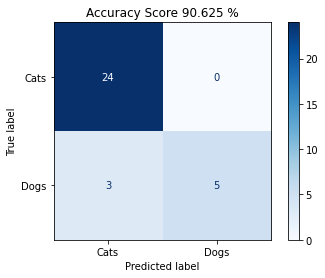

In [13]:
cm = confusion_matrix(y_true,y_test)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=['Cats','Dogs'])
acc = accuracy_score(y_true,y_test) * 100



fig, ax = plt.subplots()
plt.title(f"Accuracy Score {acc} %")
cm_plot.plot(cmap='Blues',ax=ax)

In [14]:
print(classification_report(y_true,y_test))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        24
           1       1.00      0.62      0.77         8

    accuracy                           0.91        32
   macro avg       0.94      0.81      0.86        32
weighted avg       0.92      0.91      0.90        32

